In [1]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ../setup_notebook.ipynb

In [6]:
from opto_stim_import2 import BlimpImport
import pickle
from utils.utils_funcs import d_prime

sys.path.append(os.path.expanduser('~/Documents/code'))
import wampl.wes as wes
wes.set_palette('FantasticFox1')
plt.rcParams['pdf.fonttype'] = 42

In [7]:
figure_path = '/home/jrowland/mnt/qnap/Figures/bois'
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

In [8]:
mice_dicts = [
    
{'mouse_id': 'J048'},
{'mouse_id': 'RL048'},
{'mouse_id': 'J063'},
{'mouse_id': 'J064'},
{'mouse_id': 'J065'},
#{'mouse_id': 'RL070'},
{'mouse_id': 'RL072'},
    
]

mice_dicts_controls = [
    
{'mouse_id': 'J045'},
{'mouse_id': 'J046'},
{'mouse_id': 'RL037'},
{'mouse_id': 'RL038'},
    
]

In [9]:
for mouse_dict in mice_dicts:
    mouse_obj = BlimpImport(mouse_dict['mouse_id'])
    mouse_dict['runs'] = mouse_obj.import_1p()
    
for mouse_dict in mice_dicts_controls:
    mouse_obj = BlimpImport(mouse_dict['mouse_id'])
    mouse_dict['runs'] = mouse_obj.import_1p()

['/home/jrowland/mnt/qnap/Data/2019-06-12/Behaviour1/J048-2019-06-12-164549.txt']
Importing data file: J048-2019-06-12-164549.txt
['/home/jrowland/mnt/qnap/Data/2019-06-13/Behaviour1/J048-2019-06-13-160645.txt']
Importing data file: J048-2019-06-13-160645.txt
['/home/jrowland/mnt/qnap/Data/2019-06-14/Behaviour1/J048-2019-06-14-163539.txt']
Importing data file: J048-2019-06-14-163539.txt
['/home/jrowland/mnt/qnap/Data/2019-06-12/Behaviour1/RL048-2019-06-12-181929.txt']
Importing data file: RL048-2019-06-12-181929.txt
['/home/jrowland/mnt/qnap/Data/2019-06-13/Behaviour1/RL048-2019-06-13-172939.txt']
Importing data file: RL048-2019-06-13-172939.txt
['/home/jrowland/mnt/qnap/Data/2019-06-14/Behaviour1/RL048-2019-06-14-175540.txt']
Importing data file: RL048-2019-06-14-175540.txt
['/home/jrowland/mnt/qnap/Data/2019-06-16/Behaviour1/RL048-2019-06-16-221750.txt']
Importing data file: RL048-2019-06-16-221750.txt
['/home/jrowland/mnt/qnap/Data/2019-06-18/Behaviour1/RL048-2019-06-18-203211.txt']

In [26]:
def get_power_arr(runs):
    
    powers_on_sample = [10,5,2,1,0.5,0.2,0.1]
    
    LED_currents = []
    for run in runs:
        if run.session.task_name == 'opto_stim_psychometric':
            continue
        else:
            [LED_currents.append(l) for l in run.LED_current]
    switch_trials = [i for i,d in enumerate(np.diff(LED_currents)) if d != 0] 
    
    power_arr = np.zeros(len(LED_currents)) - 100
    
    for i in range(len(switch_trials)):

        if i == 0: 
            power_arr[0:switch_trials[0]] = powers_on_sample[0]
        elif i == len(switch_trials)-1:
            power_arr[switch_trials[i]:] = powers_on_sample[-1]
        
        power_arr[switch_trials[i-1]:switch_trials[i]] = powers_on_sample[i-1]
            
    return power_arr

In [27]:
def ladder_plot(mice_dicts, color=0, label=None):
    
    power_arrs = []
    
    for mouse_dict in mice_dicts:
    
        power_arrs.append(get_power_arr(mouse_dict['runs']))

    maxlen =  max([len(a) for a in power_arrs]) 
    tomean = np.zeros((maxlen, len(power_arrs)))

    for i, arr in enumerate(power_arrs):
        arr = np.append(arr,[np.nan]*(maxlen - len(arr)))
        tomean[:,i] = arr

    meaned = np.nanmean(tomean,1)
    
    plt.plot(meaned, color=sns.color_palette()[color], label=label)
    
    for arr in power_arrs:
        plt.plot(arr, color=sns.color_palette()[color], alpha=0.2)
        

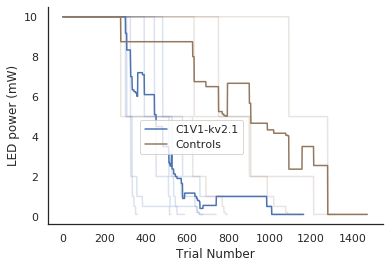

In [28]:
plt.figure()

power_arrs = ladder_plot(mice_dicts, label='C1V1-kv2.1')
power_arrs = ladder_plot(mice_dicts_controls, label='Controls', color=5)

plt.xlabel('Trial Number')
plt.ylabel('LED power (mW)')
plt.legend(bbox_to_anchor=(0.6, 0.4))
sns.despine()
plt.savefig(os.path.join(figure_path, 'kv21_ladder.pdf'),bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'kv21_ladder.png'),bbox_inches="tight")

In [29]:
def get_autoswitch(mice_dicts):
       
    autoswitches = []
      
    for mouse_dict in mice_dicts: 
        autoswitch = 0
        for run in mouse_dict['runs']:
            if not run.trial_autoswitch:
                autoswitch += run.n_trials_complete
            else:
                autoswitch += run.trial_autoswitch
                break
                
        autoswitches.append(autoswitch)
                
    return autoswitches

In [30]:
def bar_plotter(data, labels, save_name, ypos, ylab = 'Trials to Criterion'):
    
    fig = plt.figure()

    mean_data = [np.nanmean(d) for d in data]
    bar_width = 0.9
    for i,d in enumerate(data):
        plt.plot([ypos[i]]*len(d), d, '.', color=sns.color_palette()[6], markersize=15)
    plt.bar(ypos, mean_data, bar_width)
    plt.xticks(ypos, labels)
    plt.ylabel(ylab)
    fig.autofmt_xdate()
    sns.despine()
    plt.savefig(os.path.join(figure_path, save_name + '.pdf'), )
    plt.savefig(os.path.join(figure_path, save_name + '.png'), bbox_inches="tight")

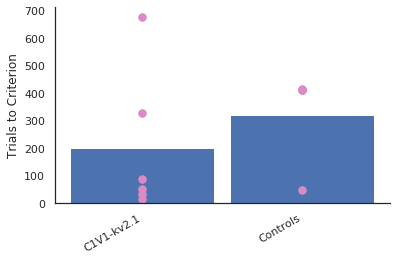

In [31]:
data = [get_autoswitch(mice_dicts), get_autoswitch(mice_dicts_controls)]
labels = ('C1V1-kv2.1', 'Controls')
save_name = 'Trial_autoswitch'
ypos = [0,1]

bar_plotter(data, labels, save_name, ypos)

In [32]:
def get_dprimes(mice_dicts):
    
    dprimes = []
    for mouse_dict in mice_dicts:
        for run in mouse_dict['runs']:
            if run.session.task_name == 'opto_stim_psychometric':
                continue
            else:
                dprimes.append(run.dprime)
                
    return dprimes

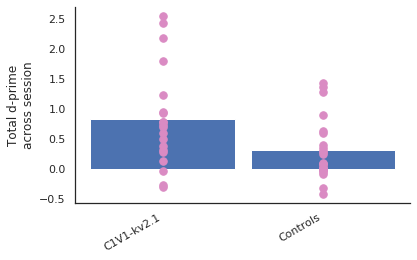

In [33]:
bar_plotter([get_dprimes(mice_dicts), get_dprimes(mice_dicts_controls)], labels, '1-photon-dprimes',
            ypos, ylab='Total d-prime\nacross session')


In [34]:
mouse_obj = BlimpImport('J063')
runs =  mouse_obj.import_1p()
run = runs[2]

['/home/jrowland/mnt/qnap/Data/2019-11-27/Behaviour1/J063-2019-11-27-223718.txt']
Importing data file: J063-2019-11-27-223718.txt
['/home/jrowland/mnt/qnap/Data/2019-11-28/Behaviour1/J063-2019-11-28-163651.txt']
Importing data file: J063-2019-11-28-163651.txt
['/home/jrowland/mnt/qnap/Data/2019-11-29/Behaviour1/J063-2019-11-29-175026.txt']
Importing data file: J063-2019-11-29-175026.txt
['/home/jrowland/mnt/qnap/Data/2019-12-03/Behaviour1/J063-2019-12-03-220849.txt']
Importing data file: J063-2019-12-03-220849.txt
['/home/jrowland/mnt/qnap/Data/2019-12-04/Behaviour1/J063-2019-12-04-232342.txt']
Importing data file: J063-2019-12-04-232342.txt


In [35]:
x = get_dprimes(mice_dicts)

In [37]:
len(x)

20

In [39]:
mice_dicts

[{'mouse_id': 'J048',
  'runs': [<opto_stim_import2.OptoStim1p at 0x7f931dde94d0>,
   <opto_stim_import2.OptoStim1p at 0x7f931dde9790>]},
 {'mouse_id': 'RL048',
  'runs': [<opto_stim_import2.OptoStim1p at 0x7f93218ed510>,
   <opto_stim_import2.OptoStim1p at 0x7f9321921b90>]},
 {'mouse_id': 'J063',
  'runs': [<opto_stim_import2.OptoStim1p at 0x7f93205c9b90>,
   <opto_stim_import2.OptoStim1p at 0x7f9322da4bd0>]},
 {'mouse_id': 'J064',
  'runs': [<opto_stim_import2.OptoStim1p at 0x7f9320a83290>,
   <opto_stim_import2.OptoStim1p at 0x7f9320e6df90>]},
 {'mouse_id': 'J065',
  'runs': [<opto_stim_import2.OptoStim1p at 0x7f9352ef1e50>,
   <opto_stim_import2.OptoStim1p at 0x7f931ea3f4d0>]},
 {'mouse_id': 'RL072',
  'runs': [<opto_stim_import2.OptoStim1p at 0x7f93218e4350>,
   <opto_stim_import2.OptoStim1p at 0x7f9321133ed0>]}]

In [43]:
mouse_dict = mice_dicts[0]

x = get_power_arr(mouse_dict['runs'])

In [44]:
x

array([10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10

In [101]:
pm_runs = []
for mouse_dict in mice_dicts:
    for run in mouse_dict['runs']:
        if run.session.task_name == 'opto_stim_psychometric':
            pm_runs.append(run)

[[],

In [54]:
len(run.LED_current)

140

In [55]:
len(run.outcome)

220

In [61]:



len(go)

140

In [75]:
len(currents)

6

In [115]:
mw = [0.5, 0.1,0.08,0.06,0.04,0.02]
mw = np.flip(mw)

6

In [72]:
np.sort(currents)

array([0.15     , 0.29     , 0.42     , 0.56     , 0.6900001, 2.82     ])

In [138]:
psychos = []




for idx, run in enumerate(pm_runs):
    
    # Poor session
    if idx == 3:
        continue

    LED_currents = run.LED_current
    currents = np.unique(LED_currents)

    n_fp = (run.outcome=='fp').sum()
    n_cr = (run.outcome=='cr').sum()

    go_idx = np.where((run.outcome=='hit') | (run.outcome=='miss') )[0]
    go = run.outcome[go_idx]

    fp_rate = n_fp / (n_fp + n_cr)
    
    dps = []
    for c in np.sort(currents):
        c_idx = np.where(LED_currents==c)

        outcome = go[c_idx]

        n_hits = (outcome=='hit').sum()
        n_miss = (outcome=='miss').sum()

        hit_rate = n_hits / (n_hits + n_miss)

        dp = d_prime(hit_rate, fp_rate)
        
        dps.append(dp)
    psychos.append(dps)


psychos = np.array(psychos)


In [139]:
psychos.shape

(5, 6)

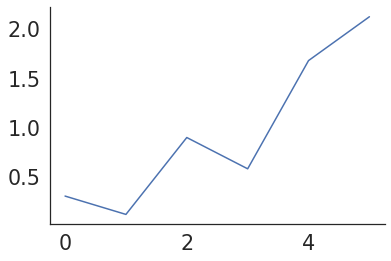

In [140]:
plt.plot(np.mean(psychos,0))

In [149]:
psychos = psychos[:, 0:5]
mw = mw[0:5]


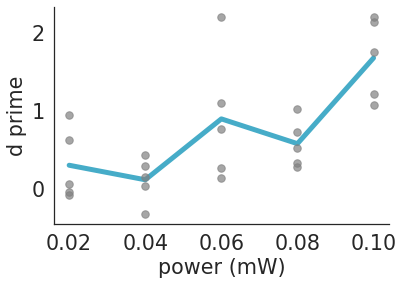

In [208]:
wes_cols = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    wes_cols[ii] = x['color']
    if ii > 8:
        break
        
        
plt.plot(mw, meaned,  linewidth=5, linestyle='-', 
        markersize=15, color=wes_cols[2], label=None, alpha=1)

meaned = np.mean(psychos,0)


for i in range(psychos.shape[0]):
    plt.plot(mw, psychos[i,:], '.', markersize=15, alpha=0.7, color='grey')
plt.xlabel('power (mW)')
plt.ylabel('d prime')
plt.savefig(os.path.join(figure_path, '1-photon_dps.pdf'),
            transparent=True, bbox_inches='tight')

In [142]:
psychos

array([[-0.07671567,  0.29477239,  0.26688029,  1.02847973,  1.07054103,
         2.24545893],
       [-0.03387984, -0.32726105,  0.14613253,  0.2847595 ,  2.14018857,
         2.14018857],
       [ 0.06426475,  0.15070445,  1.0977543 ,  0.73297877,  1.75882853,
         1.75882853],
       [ 0.62095684,  0.43259671,  0.77102711,  0.52728552,  1.21913615,
         2.27062702],
       [ 0.9420508 ,  0.03387984,  2.20794824,  0.32726105,  2.20794824,
         2.20794824]])